In [2]:
import os
import json
import random
import pandas as pd
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [3]:
#Load VQA v2 Dataset

DATA_DIR = "/kaggle/input/vqav2-train"

IMG_DIR = f"{DATA_DIR}/train2014/train2014"
Q_PATH = f"{DATA_DIR}/v2_Questions_Train_mscoco/v2_OpenEnded_mscoco_train2014_questions.json"
A_PATH = f"{DATA_DIR}/v2_Annotations_Train_mscoco/v2_mscoco_train2014_annotations.json"

with open(Q_PATH, "r") as f:
    questions = json.load(f)["questions"]

with open(A_PATH, "r") as f:
    annotations = json.load(f)["annotations"]

print("Questions:", len(questions))
print("Annotations:", len(annotations))

Questions: 443757
Annotations: 443757


In [4]:
SAMPLE_SIZE = 5000
indices = random.sample(range(len(questions)), SAMPLE_SIZE)

questions = [questions[i] for i in indices]
annotations = [annotations[i] for i in indices]


In [5]:
#Cleaning & Normalization

def normalize_text(text):
    return text.lower().strip()

clean_data = []

for q, a in zip(questions, annotations):
    question = normalize_text(q["question"])
    
    answers = [normalize_text(ans["answer"]) for ans in a["answers"]]
    
    if len(question.split()) < 3:
        continue
    
    most_common_answer = max(set(answers), key=answers.count)
    
    clean_data.append({
        "image_id": q["image_id"],
        "question": question,
        "answer": most_common_answer
    })

print("Clean samples:", len(clean_data))


Clean samples: 4999


In [6]:
#Image Preprocessing (Resize + RGB)

PROCESSED_IMG_DIR = "/kaggle/working/processed_images"
os.makedirs(PROCESSED_IMG_DIR, exist_ok=True)

def preprocess_image(image_id):
    img_name = f"COCO_train2014_{str(image_id).zfill(12)}.jpg"
    img_path = os.path.join(IMG_DIR, img_name)
    
    img = Image.open(img_path).convert("RGB")
    img = img.resize((224, 224))
    
    save_path = os.path.join(PROCESSED_IMG_DIR, img_name)
    img.save(save_path)
    
    return save_path


In [7]:
final_samples = []

for item in tqdm(clean_data):
    try:
        img_path = preprocess_image(item["image_id"])
        final_samples.append({
            "image_path": img_path,
            "question": item["question"],
            "answer": item["answer"]
        })
    except:
        continue

df = pd.DataFrame(final_samples)
print(df.head())


100%|██████████| 4999/4999 [01:05<00:00, 75.77it/s]

                                          image_path  \
0  /kaggle/working/processed_images/COCO_train201...   
1  /kaggle/working/processed_images/COCO_train201...   
2  /kaggle/working/processed_images/COCO_train201...   
3  /kaggle/working/processed_images/COCO_train201...   
4  /kaggle/working/processed_images/COCO_train201...   

                                          question           answer  
0                            what color is fridge?           silver  
1  is there more than once sandwich on this scene?              yes  
2                         what color is the truck?            black  
3                         what color is the photo?  black and white  
4                                   is this a zoo?               no  


In [8]:
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print("Train:", len(train_df))
print("Validation:", len(val_df))
print("Test:", len(test_df))


Train: 3999
Validation: 500
Test: 500


In [9]:
train_df.to_csv("/kaggle/working/train.csv", index=False)
val_df.to_csv("/kaggle/working/val.csv", index=False)
test_df.to_csv("/kaggle/working/test.csv", index=False)

**BLIP image captioning code**

In [11]:
!pip install -q transformers timm accelerate

In [12]:
import torch
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
import pandas as pd

2025-12-27 04:40:02.552376: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766810402.805525      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766810402.878247      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766810403.486263      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766810403.486314      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766810403.486317      55 computation_placer.cc:177] computation placer alr

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained(
    "Salesforce/blip-image-captioning-base"
).to(device)

print("Model loaded on:", device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

Model loaded on: cpu


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [14]:
train_df = pd.read_csv("/kaggle/working/train.csv")
train_df.head()

,image_path,question,answer
0,/kaggle/working/processed_images/COCO_train201...,is the bird sitting on a tree?,yes
1,/kaggle/working/processed_images/COCO_train201...,what is the subject of the book?,history
2,/kaggle/working/processed_images/COCO_train201...,what top is the man wearing?,green shirt
3,/kaggle/working/processed_images/COCO_train201...,what type of beer is in the picture?,harpoon
4,/kaggle/working/processed_images/COCO_train201...,how many monitors do you see?,1


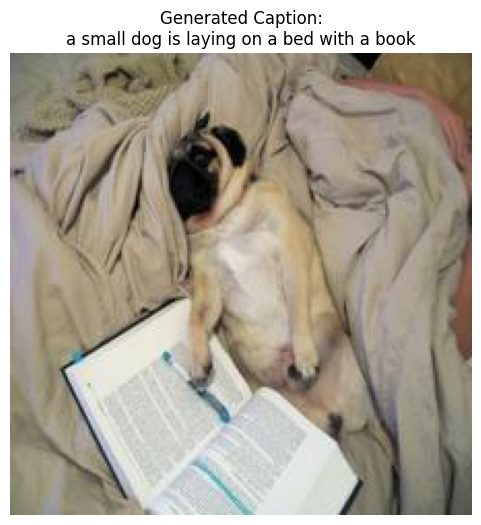

In [19]:
import matplotlib.pyplot as plt

sample_image_path = train_df.iloc[1]["image_path"]

image = Image.open(sample_image_path).convert("RGB")

inputs = processor(images=image, return_tensors="pt").to(device)

with torch.no_grad():
    output = model.generate(**inputs, max_length=30)

caption = processor.decode(output[0], skip_special_tokens=True)

plt.figure(figsize=(6,6))
plt.imshow(image)
plt.axis("off")
plt.title(f"Generated Caption:\n{caption}", fontsize=12)
plt.show()


In [20]:
def generate_caption(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        output = model.generate(**inputs, max_length=30)
    return processor.decode(output[0], skip_special_tokens=True)

train_df["caption"] = train_df["image_path"].head(10).apply(generate_caption)
train_df[["image_path", "caption"]].head(10)


,image_path,caption
0,/kaggle/working/processed_images/COCO_train201...,a monkey in the trees
1,/kaggle/working/processed_images/COCO_train201...,a small dog is laying on a bed with a book
2,/kaggle/working/processed_images/COCO_train201...,a person on a skateboard on a sidewalk
3,/kaggle/working/processed_images/COCO_train201...,a plate of pizza and a bottle of beer
4,/kaggle/working/processed_images/COCO_train201...,a computer on a desk
5,/kaggle/working/processed_images/COCO_train201...,a white truck
6,/kaggle/working/processed_images/COCO_train201...,a man on a skateboard
7,/kaggle/working/processed_images/COCO_train201...,the dark knight joker
8,/kaggle/working/processed_images/COCO_train201...,a group of gis
9,/kaggle/working/processed_images/COCO_train201...,a man in a blue shirt


In [21]:
train_df.head(100).to_csv("/kaggle/working/train_with_captions.csv", index=False)

**BLIP VQA code**

In [38]:
!pip install -q transformers timm

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [39]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
from transformers import ViltProcessor, ViltForQuestionAnswering


In [40]:
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = ViltProcessor.from_pretrained(
    "dandelin/vilt-b32-finetuned-vqa"
)
model = ViltForQuestionAnswering.from_pretrained(
    "dandelin/vilt-b32-finetuned-vqa"
).to(device)

print("ViLT VQA model loaded on:", device)


preprocessor_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/470M [00:00<?, ?B/s]

ViLT VQA model loaded on: cpu


In [52]:
sample = train_df.iloc[0]

image = Image.open(sample["image_path"]).convert("RGB")

question = "What is the bird sitting on?"


In [53]:
inputs = processor(
    image,
    question,
    return_tensors="pt"
).to(device)

with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
predicted_id = logits.argmax(-1).item()

answer = model.config.id2label[predicted_id]

print("Question:", question)
print("Predicted Answer:", answer)


Question: What is the bird sitting on?
Predicted Answer: branch


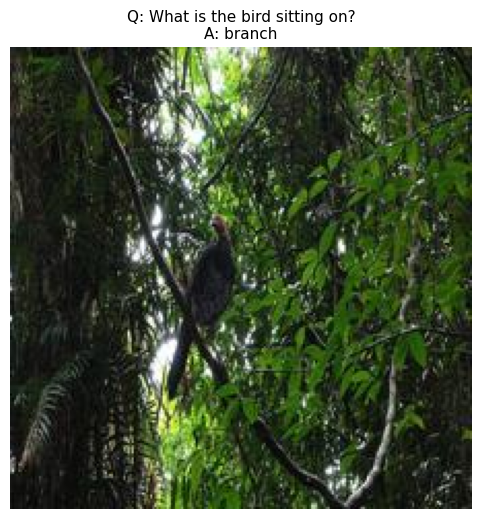

In [54]:
plt.figure(figsize=(6,6))
plt.imshow(image)
plt.axis("off")
plt.title(f"Q: {question}\nA: {answer}", fontsize=11)
plt.show()

**END-TO-END PIPELINE**

In [55]:
import torch
from PIL import Image
from transformers import (
    BlipProcessor, BlipForConditionalGeneration,
    ViltProcessor, ViltForQuestionAnswering
)


In [56]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# BLIP for Image Captioning
caption_processor = BlipProcessor.from_pretrained(
    "Salesforce/blip-image-captioning-base"
)
caption_model = BlipForConditionalGeneration.from_pretrained(
    "Salesforce/blip-image-captioning-base"
).to(device)

# ViLT for VQA
vqa_processor = ViltProcessor.from_pretrained(
    "dandelin/vilt-b32-finetuned-vqa"
)
vqa_model = ViltForQuestionAnswering.from_pretrained(
    "dandelin/vilt-b32-finetuned-vqa"
).to(device)

print("Models loaded successfully")


Models loaded successfully


In [57]:
def vqa_pipeline(image_path, question):
    image = Image.open(image_path).convert("RGB")

    # -------- Step 1: Image Captioning --------
    caption_inputs = caption_processor(
        images=image, return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        caption_ids = caption_model.generate(
            **caption_inputs,
            max_length=30
        )

    caption = caption_processor.decode(
        caption_ids[0],
        skip_special_tokens=True
    )

    # -------- Step 2: Visual Question Answering --------
    vqa_inputs = vqa_processor(
        image,
        question,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = vqa_model(**vqa_inputs)

    logits = outputs.logits
    predicted_id = logits.argmax(-1).item()
    answer = vqa_model.config.id2label[predicted_id]

    return {
        "caption": caption,
        "question": question,
        "answer": answer
    }


In [61]:
sample_image = train_df.iloc[0]["image_path"]

result = vqa_pipeline(
    sample_image,
    "What is the monkey doing?"
)

print("Caption :", result["caption"])
print("Question:", result["question"])
print("Answer  :", result["answer"])


Caption : a monkey in the trees
Question: What is the monkey doing?
Answer  : sitting
